In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pickle

import sys
sys.path.append('../')
from py.mylib import *
device = "cuda"

In [2]:
target = importTarget("..\data\images\mitosis_img_005.json")

100%|██████████| 976/976 [00:07<00:00, 129.87it/s]


In [3]:
img = importPicture("..\data\images\mitosis_img_005.jpg").reshape(1, 3, 1040, 788)
print(img.shape)

torch.Size([1, 3, 1040, 788])


In [4]:
x_train = partition(img)

100%|██████████| 1008/1008 [00:08<00:00, 117.44it/s]


In [5]:
y_train = target.reshape(-1, 1)

In [6]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()


def fit(epochs, model, loss_func, opt, train_dl, valid_dl = None):
    val_loss = [0] * epochs
    for epoch in (range(epochs)):
        model.train()
        for (xb, yb) in tqdm(train_dl):
            xb , yb = xb.to(device), yb.to(device)
            loss_batch(model, loss_func, xb, yb, opt)
            val_loss[epoch] += loss_batch(model, loss_func, xb, yb, opt)
        print(val_loss[epoch])
        pickle.dump(model, open('model.sav', 'wb'))
    return val_loss

def get_data(train_ds, bs, shuffle = True):
    return(DataLoader(train_ds, batch_size=bs, shuffle=shuffle))

In [7]:
bs = 560
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
train_dl = get_data(train_ds, bs)
x_train.shape

torch.Size([762048, 3, 32, 32])

### Model

In [8]:
loss_func = nn.MSELoss()

In [9]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.lin1 = nn.Linear(16*32*32, 32*32)
        self.lin64 = nn.Linear(32*32, 32*32)
        self.lin32 = nn.Linear(32*32, 32*16)
        self.lin16 = nn.Linear(32*16, 64)
        self.linf = nn.Linear(64, 1)

        self.int = nn.Linear(1024, 32*32)
    def forward(self, xb):
        xb = torch.tanh(self.conv1(xb))
        xb = torch.tanh(self.conv2(xb))
        xb = torch.tanh(self.conv3(xb))
        #xb = xb.reshape(bs, -1)
        #xb = torch.tanh(self.int(xb))
        xb = torch.tanh(self.lin1(xb.flatten(1)))
        xb = torch.tanh(self.lin64(xb))
        xb = torch.tanh(self.lin64(xb))
        xb = torch.tanh(self.lin64(xb))
        xb = torch.tanh(self.lin32(xb))
        xb = torch.tanh(self.lin16(xb))
        xb = F.relu(self.linf(xb))
        return xb.reshape(-1, 1)


In [10]:
def get_model():
    model = SimpleClassifier().to(device)
    return model, torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
model, opt = get_model()

In [12]:
train_dl = get_data(train_ds, bs)
lossplt = fit(1, model, loss_func, opt, train_dl)

100%|██████████| 1361/1361 [01:00<00:00, 22.68it/s]


167.16577462106943


[167.16577462106943]


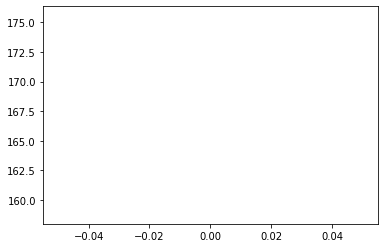

In [13]:
plt.plot(lossplt)
print(lossplt)

In [51]:

img = importPicture("../data/images/mitosis_img_005.jpg")

In [52]:
bs = 576
with torch.no_grad():
    model.eval()
    x_train = partition(img).reshape(-1, 3, 32, 32)
    train_dl = get_data(x_train, bs, False)

100%|██████████| 1008/1008 [00:07<00:00, 135.10it/s]


In [53]:
    image = torch.empty((len(train_dl), bs, 1))
    print(image.shape)
    for i, x in enumerate(tqdm(train_dl)):
        image[i] = model(x.to(device)).cpu().detach()

torch.Size([1323, 576, 1])


100%|██████████| 1323/1323 [00:13<00:00, 96.02it/s] 


torch.Size([1323, 576, 1])
tensor(1.6076)


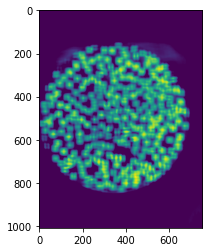

In [54]:
print(image.shape)
print(image.max())
plt.imshow(image.reshape(1008, -1))

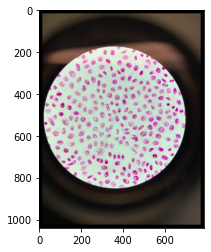

In [55]:
plt.imshow(transforms.ToPILImage()(img))

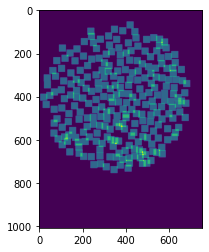

In [49]:
plt.imshow(y_train.reshape(1008, -1))

In [57]:
print(cellCount(image))
print(cellCount(y_train))

tensor(251.2379)
tensor(256.)
